<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#识别你的宠物：37种猫狗" data-toc-modified-id="识别你的宠物：37种猫狗-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>识别你的宠物：37种猫狗</strong></a></span><ul class="toc-item"><li><span><a href="#熟悉你的数据" data-toc-modified-id="熟悉你的数据-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>熟悉你的数据</a></span></li><li><span><a href="#训练模型resnet34" data-toc-modified-id="训练模型resnet34-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>训练模型resnet34</a></span></li><li><span><a href="#训练成果" data-toc-modified-id="训练成果-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>训练成果</a></span></li><li><span><a href="#解冻，微调，学习率" data-toc-modified-id="解冻，微调，学习率-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>解冻，微调，学习率</a></span></li><li><span><a href="#训练模型-resnet50" data-toc-modified-id="训练模型-resnet50-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>训练模型 resnet50</a></span></li><li><span><a href="#其他制作DataBunch的方法" data-toc-modified-id="其他制作DataBunch的方法-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>其他制作<code>DataBunch</code>的方法</a></span></li></ul></li></ul></div>

# **识别你的宠物：37种猫狗**

[**源自 fast.ai v3 2019课程中文笔记**](https://forums.fast.ai/t/fast-ai-v3-2019/39325)    
这里是原Notebook的简易中文版，目的是帮助大家快速上手了解第一课代码知识点



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
from fastai.vision import * # 加载所需的几乎所有工具
from fastai.metrics import error_rate # 补充工具
from fastai.basics import *
from fastai.callbacks import *

In [3]:
# bs = 64 # 一次处理64张图片，但如果内存不够（bus error)，则需要重启kernel, 将64缩小为16，降低内存需求
# bs = 16 # `0` + `0` = 重启kernel
bs = 8

## 熟悉你的数据

数据官网 [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)      
数据论文 [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) 
37种猫狗 = 12 cat breeds + 25 dogs breeds    
我们模型的目标是区分这37种不同类别的猫狗    

---

**难度认知**    
随机猜的胜率$1/37$，远低于50%；       
2012年的学术顶级水平是80%左右的准确率；       
跑完这个Notebook，你会惊讶自己与顶级深度学习模型水准的距离，只有一个fast.ai       

---

In [5]:
# 下载解压数据包，并生成数据文件地址
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls() # 查看数据文件内容

[WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images' # 进一步找到直接存有数据文件夹

In [8]:
fnames = get_image_files(path_img) # 将所有数据图片，做成地址Path,放入一个list中
fnames[:5] # 查看list

[WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/Yang/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [11]:
np.random.seed(2) # 确保每次训练后，模型都被相同的验证数据验证
pat = r'/([^/]+)_\d+.jpg$' # 用re从文件名中提取图片label标注

`pat`是如何提取图片名称的？见[工作原理](https://github.com/EmbraceLife/shendusuipian/issues/62), [notebook实验](https://www.kaggle.com/danielliao/regexpr-label)

In [14]:
??ImageDataBunch.from_name_re

In [12]:
# 生成数据集（包含训练集和验证集，测试集可选）
data = ImageDataBunch.from_name_re(path_img, # 图片数据文件夹path
                                   fnames, # 图片path的list
                                   pat, # regexpr 
                                   ds_tfms=get_transforms(), # 图片所需的处理
                                   size=224, # 图片裁剪大小, but having bus error,
#                                    size=56, # 缩小图片
                                   bs=bs # 一次处理图片数量
                                  ).normalize(imagenet_stats) # 图片处理的均值与方差

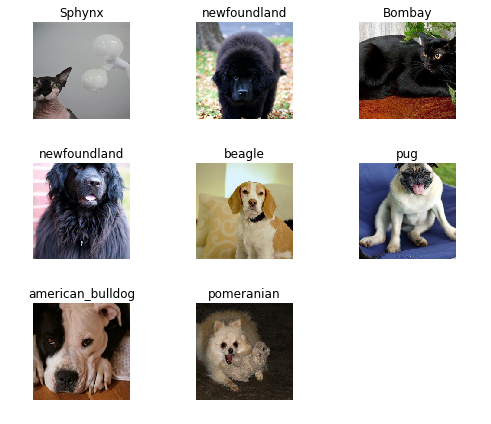

In [13]:
data.show_batch(rows=3, figsize=(7,6)) # 展示数据

In [17]:
print(data.classes) # 打印类别名称
len(data.classes),data.c # 类别总数

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## 训练模型resnet34

现在我们开始训练模型。模型主干是CNN [convolutional neural network](http://cs231n.github.io/convolutional-networks/) 外加一个全链接含一个隐藏层的分类器。之后课程中我们会深入学习CNN，现在只需要知道我们的模型可以“吃进”图片“吐出”种类识别（从37个类别中）。

In [18]:
# 创建一个CNN模型，使用data作为数据，下载和调用resnet34作为模型框架和参数，同时打印错误率
learn = create_cnn(data, models.resnet34, metrics=error_rate) 

C:\Users\Yang\AppData\Local\conda\conda\envs\PyTorch\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Yang/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████| 87306240/87306240 [00:13<00:00, 6640799.98it/s]


In [19]:
learn.model # 查看模型内在结构

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [25]:
model_summary(learn)

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

In [26]:
learn.fit_one_cycle(1) # 训练模型，完整训练数据集一遍

epoch,train_loss,valid_loss,error_rate,time
0,0.737626,0.307687,0.092693,03:38


In [28]:
learn.save('stage-1') # 将模型保存在工作目录下

## 训练成果

我们看看训练成果
首先，看看模型最容易混淆的种类。也就是看看出错是否在情理之中。如果错是犯在了很难分辨的地方，这说明模型还不错。
然后，画出confusion matrix，可以看出分布是不对称的；如果模型在相同的地方反复犯错，而其他类别则没问题。这意味着模型只是针对某些类别易出错。以上都是很正常的现象。

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

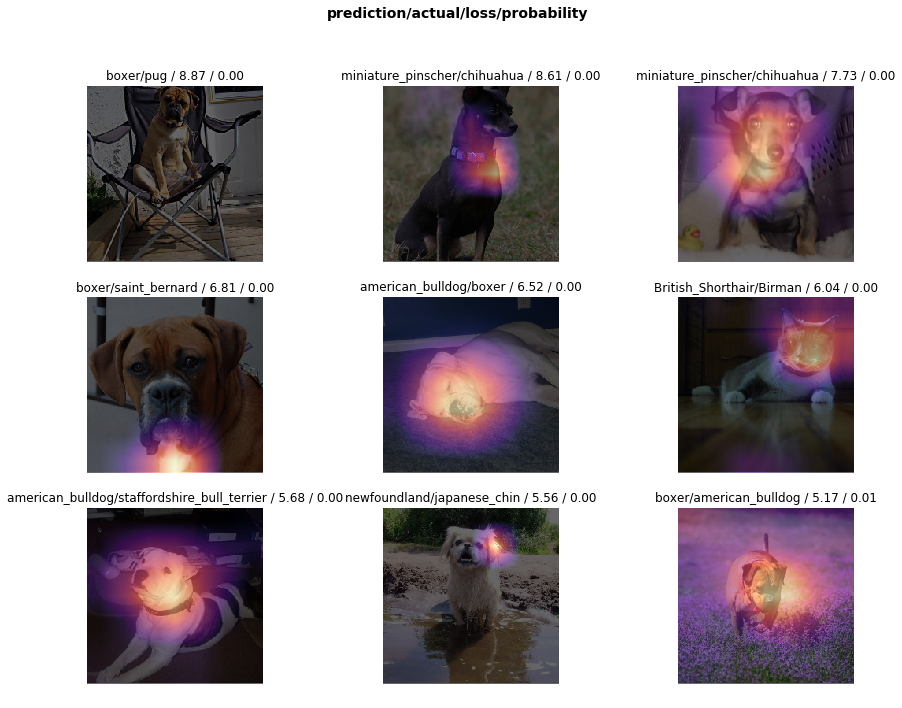

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

In [31]:
doc(interp.plot_top_losses)

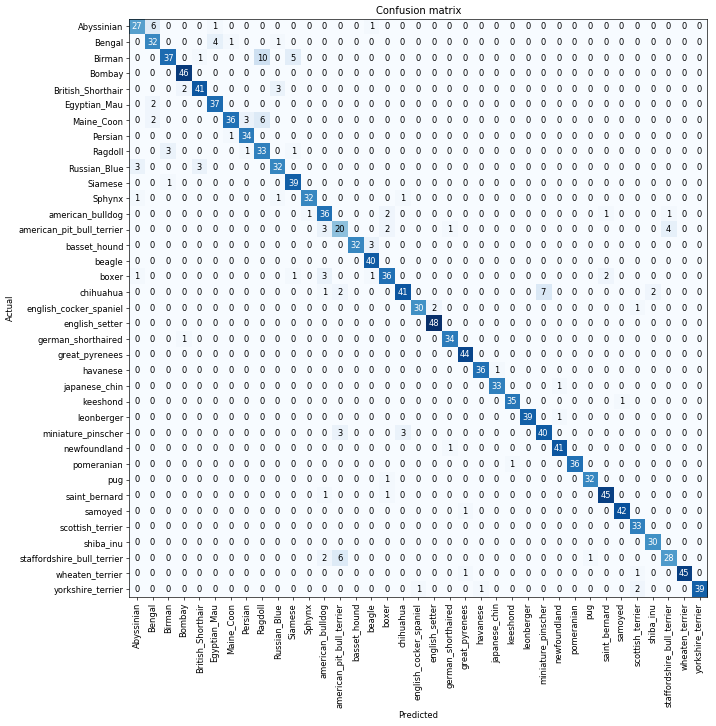

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [33]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 10),
 ('chihuahua', 'miniature_pinscher', 7),
 ('Abyssinian', 'Bengal', 6),
 ('Maine_Coon', 'Ragdoll', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Birman', 'Siamese', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Maine_Coon', 'Persian', 3),
 ('Ragdoll', 'Birman', 3),
 ('Russian_Blue', 'Abyssinian', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('american_pit_bull_terrier', 'american_bulldog', 3),
 ('basset_hound', 'beagle', 3),
 ('boxer', 'american_bulldog', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('British_Shorthair', 'Bombay', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('boxer', 'saint_bernard', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('chihuahua', 'shiba_i

## 解冻，微调，学习率

既然模型工作正常，我们可以开始解冻模型，做更多层的训练

In [34]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.087519,0.448538,0.129229,04:05


In [36]:
learn.load('stage-1');

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


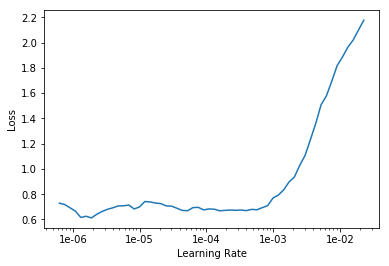

In [38]:
learn.recorder.plot()

In [39]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.632297,0.273335,0.083221,04:03


In [40]:
learn.save('stage-2')

模型的精确度已经不错了，要知道2012年的顶级水平是80%，我们仅2轮训练就高达91%

## 训练模型 resnet50

现在我们来训练更大的模型resnet50(50层而非34层）更多细节会在后续课程和这篇论文中了解 [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

基本上，resnet50会表现更好，因为它更深参数更多。采用更大的图片训练，模型可以看到更多特征，有利于模型学习。同时，我们减少一次“喂给”模型的图片数量，避免GPU内存枯竭。


In [41]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [42]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

C:\Users\Yang\AppData\Local\conda\conda\envs\PyTorch\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Yang/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|███████████████████████████████████████████████████████████████| 102502400/102502400 [00:15<00:00, 6600295.29it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


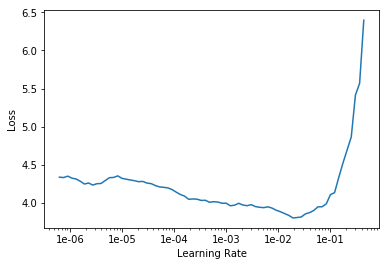

In [43]:
learn.lr_find()
learn.recorder.plot()

In [44]:
learn.fit_one_cycle(1) # 4 次是正常数量

epoch,train_loss,valid_loss,error_rate,time
0,0.988492,0.361743,0.122463,07:00


In [45]:
learn.save('stage-1-50')

In [46]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))
learn.save('stage-2-50');

epoch,train_loss,valid_loss,error_rate,time
0,0.897748,0.280172,0.094723,08:14


如果效果不好，可以调回之前的模型，继续训练

In [47]:
learn.load('stage-2-50');

In [48]:
interp = ClassificationInterpretation.from_learner(learn)

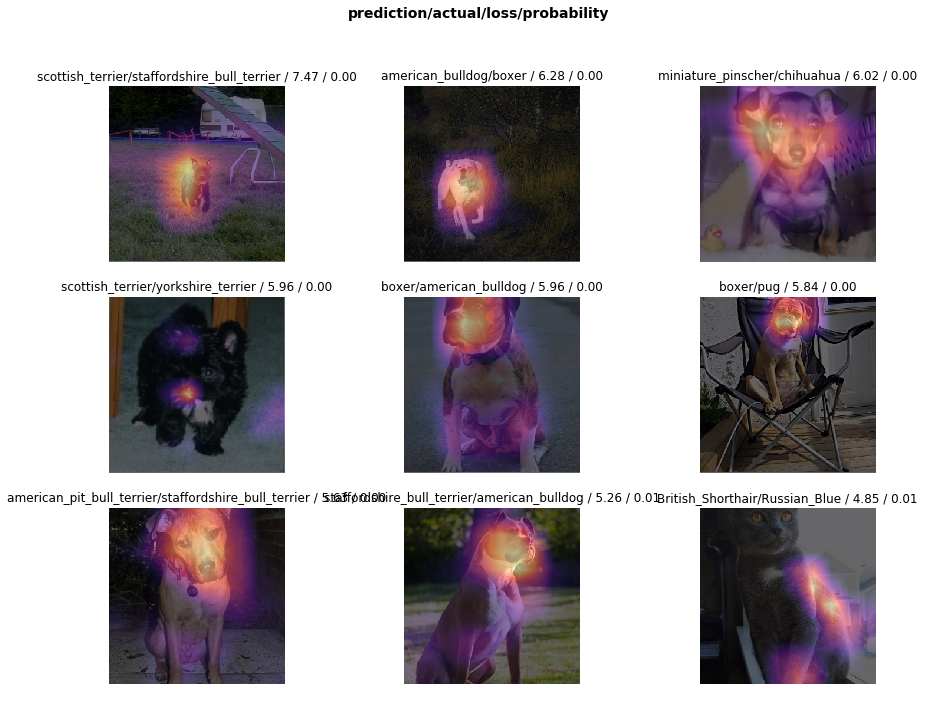

In [49]:
interp.plot_top_losses(9, figsize=(15,11))

In [50]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 13),
 ('Bengal', 'Egyptian_Mau', 11),
 ('Russian_Blue', 'British_Shorthair', 9),
 ('Ragdoll', 'Birman', 7),
 ('american_bulldog', 'boxer', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Birman', 'Siamese', 4),
 ('Russian_Blue', 'Bombay', 4),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('Abyssinian', 'Ragdoll', 3),
 ('Birman', 'Ragdoll', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('Abyssinian', 'Egyptian_Mau', 2),
 ('Bengal', 'Abyssinian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Ragdoll', 'Maine_Coon', 2),
 ('Ragdoll', 'Persian', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'beagle', 2),
 ('american_bulldog', 'saint_bernard', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('boxer', 'american_bulldog', 2),
 ('keeshond', 'leonberger', 2),
 ('shiba_inu', 'keeshond', 2)]

## 其他制作`DataBunch`的方法

In [51]:
path = untar_data(URLs.MNIST_SAMPLE); path

WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample')

In [52]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

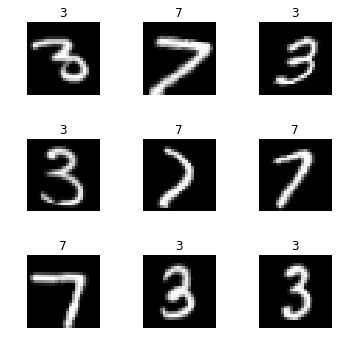

In [53]:
data.show_batch(rows=3, figsize=(5,5))

In [54]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(1)

C:\Users\Yang\AppData\Local\conda\conda\envs\PyTorch\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy,time
0,0.177240,0.098449,0.964671,01:18


In [55]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [56]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

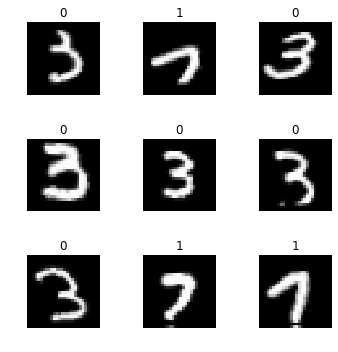

In [57]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [58]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [59]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/train/3/7463.png'),
 WindowsPath('C:/Users/Yang/.fastai/data/mnist_sample/train/3/21102.png')]

In [60]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [61]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['7']

In [62]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['7', '7', '7', '7', '7']

In [63]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['7']